In [1]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

from pyspark.context import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.jars.packages", 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0') \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-861d85d3-89fd-491d-93e7-a0fe6825ac5a;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.0.0 in central
	found org.apache.kafka#kafka-clients;2.4.1 in central
	found com.github.luben#zstd-jni;1.4.4-3 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.7.5 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 700ms :: artifacts dl 14

Be sure to start the stream on Kafka!

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType, TimestampType, DateType

schema = StructType(
      [
        StructField("name", StringType(), False),
        StructField("price", DoubleType(), False),
        StructField("timestamp", TimestampType(), False),
      ]
    )


In [3]:
kafka_server = "kafka1:9092"   
from pyspark.sql.functions import from_json

lines = (spark.readStream                        # Get the DataStreamReader
  .format("kafka")                                 # Specify the source format as "kafka"
  .option("kafka.bootstrap.servers", kafka_server) # Configure the Kafka server name and port
  .option("subscribe", "stock")                       # Subscribe to the "en" Kafka topic 
  .option("startingOffsets", "earliest")           # The start point when a query is started
  .option("maxOffsetsPerTrigger", 100)             # Rate limit on max offsets per trigger interval
  .load()
  .select(from_json(col("value").cast("string"), schema).alias("parsed_value"))
# Load the DataFrame
)
df = lines.select("parsed_value.*")


## The assignment starts here

You can create a

## Select the N most valuable stocks in a window

In [4]:
from pyspark.sql.functions import window, col


N = 10

windowedDF = df \
        .withWatermark("timestamp", "30 seconds") \
        .groupBy(window("timestamp", "5 minutes"), "name") \
        .agg({"price": "max"})

top_stocks = windowedDF.orderBy(col("window").asc(),  col("max(price)").desc()).limit(10)
top_stocks.createOrReplaceTempView("top_stocks")


# Save results
query = (top_stocks.writeStream
         .outputMode("complete")
         .format("memory")
         .queryName("MostValuableStock")
         .option("truncate", False)
         .start())



23/11/06 11:50:50 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-c9794c4a-3e1d-4433-a444-b6485be191cc. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


+------------------------------------------+-----+----------+
|window                                    |name |max(price)|
+------------------------------------------+-----+----------+
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|PCLN |819.98    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|GOOGL|414.2338  |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|AZO  |384.01    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|CMG  |378.4     |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|AMZN |269.98    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|GWW  |261.34    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|EQIX |219.94    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|IBM  |211.98    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|ISRG |192.6465  |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|ADS  |180.39    |
+------------------------------------------+-----+----------+



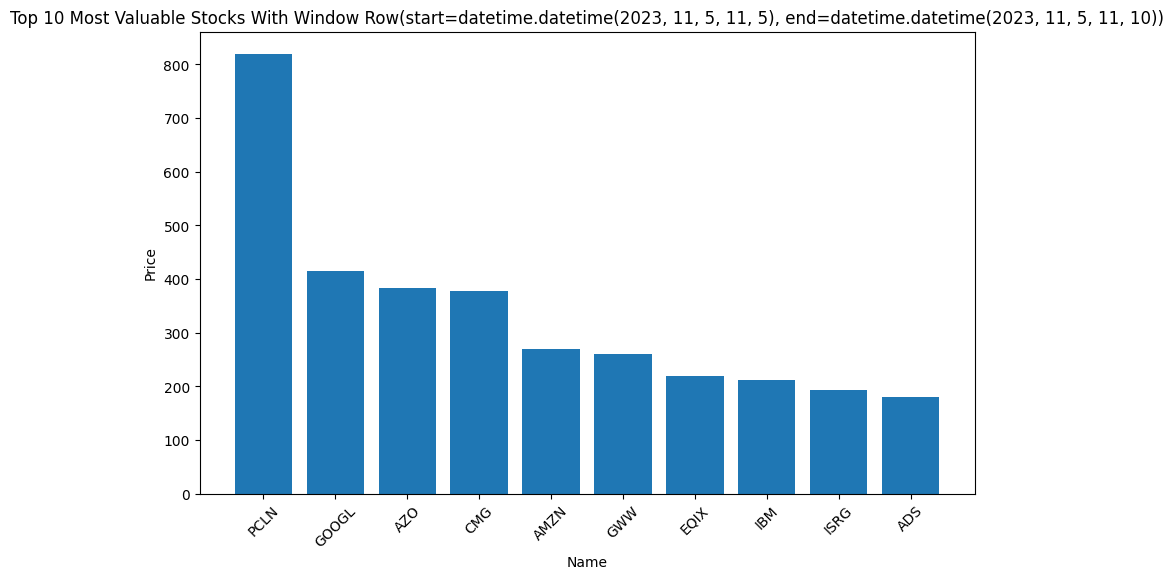

In [5]:
from matplotlib import pyplot as plt

data = spark.sql("SELECT * FROM MostValuableStock")
data.show(truncate=False)

name_list = [row["name"] for row in data.collect()]
price_list = [row["max(price)"] for row in data.collect()]
window_time = data.select("window").first()["window"]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(name_list, price_list)
plt.xlabel("Name")
plt.ylabel("Price")
plt.title(f"Top 10 Most Valuable Stocks With Window {window_time}")
plt.xticks(rotation=45)

plt.show()

In [ ]:
query.awaitTermination()